## Time Complexity Analysis -- Notebook 2
### This program is similar to the previous analysis, except we will be doing an in depth analysis of how fast the algorithms are for each strategy

#### SETUP: Import module and define PSR functions

In [89]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import time
import math
from IPython.display import clear_output



# New, more computationally expensive exposure calculation
def currentExposure(mtm):
    # Adding a more complex operation
    return max(0, mtm)

def addOn(notional, addon):
    # Adding a more complex operation
    return notional * addon

def totalExposure(mtm, notional, addOnFactor):
    currExp = currentExposure(mtm)
    currAddOn = addOn(notional, addOnFactor)

    return currExp + currAddOn

#### Define exposure calculation algorithms
#### Note how we modify the Brute Force method to use netting agreements. We don't need to use netting agreements for the other strategies. 
#### The incoming impacts are now split into their respective agreements, which means having to check each position and splitting up the total exposure several times.

In [90]:
def psrBruteForce_netting(positions, addOnFactor):
    total_time = time.time()
    aggrementsA = np.array([0,0,0])
    aggrementsB = np.array([0,0,0])
    aggrementsC = np.array([0,0,0])
    aggrementsD = np.array([0,0,0])
    aggrementsE = np.array([0,0,0])
    total = 0
    for i in range(len(positions)):

        if positions[i,2] == 1:
            row = positions[i,:]
            aggrementsA = np.vstack([aggrementsA, row])
        elif positions[i,2] == 2:
            row = positions[i,:]
            aggrementsB = np.vstack([aggrementsB, row])
        elif positions[i,2] == 3:
            row = positions[i,:]
            aggrementsC = np.vstack([aggrementsC, row])
        elif positions[i,2] == 4:
            row = positions[i,:]
            aggrementsD = np.vstack([aggrementsD, row])
        elif positions[i,2] == 5:
            row = positions[i,:]
            aggrementsE = np.vstack([aggrementsE, row])
        else:
            # Figure out what to do for the left over trades
            total += totalExposure(positions[i,0], positions[i,1], addOnFactor)

    total += psrBruteForce(aggrementsA, addOnFactor) + psrBruteForce(aggrementsB, addOnFactor) + psrBruteForce(aggrementsC, addOnFactor) + psrBruteForce(aggrementsD, addOnFactor) + psrBruteForce(aggrementsE, addOnFactor)

    total_time = time.time() - total_time
        
    return [total, total_time]

def psrBruteForce(positions, addOnFactor):
    shape = positions.shape

    if shape == (3,):
        return 0

    totalMtm = 0
    totalNotional = 0
        
    for i in range(len(positions)):

        totalMtm += positions[i,0]
        totalNotional += positions[i,1]

    total = totalExposure(totalMtm, totalNotional,addOnFactor) 

    return total


def psrConservative(positions, addOnFactor):
    
    total_time = time.time()

    total = 0

    for i in range(len(positions)):
        total += totalExposure(positions[i,0], positions[i,1], addOnFactor)

    total_time = time.time() - total_time
    return [total, total_time]

def psrLinearisation(positions, addOnFactor):
    
    total_time = time.time()
    total = 0
    baseline_position_exposure = totalExposure(positions[0, 0], positions[0,1], addOnFactor)
    total += baseline_position_exposure

    for i in range(len(positions) - 1):
        total += totalExposure(positions[0,0]+positions[i+1,0], positions[1,0]+positions[i+1,1], addOnFactor) - baseline_position_exposure
        
    total_time = time.time() - total_time

    return [total, total_time]

def psrAverages(positions, addOnFactor, n):
    
    total_time = time.time()
    total = 0
    baseline_position_exposure = totalExposure(positions[0,0], positions[0,1], addOnFactor)
    total += baseline_position_exposure

    for i in range(len(positions)-1):
        total += 1/n*(totalExposure(positions[0,0]+n*positions[i+1,0], positions[0,1]+n*positions[i+1,1], addOnFactor) - baseline_position_exposure)

    total_time = time.time() - total_time
    return [total, total_time]


def remove_decimal_places(no):
    no = np.around(no, 9)
    return no


#### We simulate the time behaviour of the functions

In [91]:
def exposure_simulation(n, addon):

    # here we want to obtain a graph showing the growth of the difference between baseline/brute force as number of trades increase
    addOnVal = 0.01


    bf_list = []
    cons_list = []
    lin_list = []
    avg_list = []

    times_bf = []
    times_cons = []
    times_lin = []
    times_avg = []
    fig,axs = plt.subplots(2,2, figsize=(10,8))

    for i in range(1,n):
    
        positions = np.zeros((i,3)) # Column 1 will be MTM, Column 2 will be Notional
        positions[0,0] = 10000
        positions[0,1] = 100000

        for j in range(i):
            positions[j,0] = random.randint(-1000,1000)
            positions[j,1] = 10*abs(positions[j,0])
            positions[j,2] = random.randint(1,8)


        [total_bf, time_bf] = psrBruteForce_netting(positions, addOnVal)  # This is our psrBruteForce, but we incorporate netting to investigate the growth 
        [total_lin, time_lin] = psrLinearisation(positions, addOnVal)
        [total_cons, time_cons] = psrConservative(positions, addOnVal)
        [total_avg, time_avg] = psrAverages(positions, addOnVal, n)

        bf_list.append(total_bf)
        cons_list.append(total_cons)
        lin_list.append(total_lin)
        avg_list.append(total_avg)

        times_bf.append(time_bf)
        times_cons.append(time_cons)
        times_lin.append(time_lin)
        times_avg.append(time_avg)

    
    x = np.arange(1,n)
    fig.subplots_adjust(hspace=0.5) 
    fig.subplots_adjust(wspace=0.5) 

    axs[0,0].plot(x,times_bf, c='r', label="Brute Force")
    axs[0,1].plot(x,times_lin, 'g', label="Linearisation")
    axs[1,0].plot(x,times_cons, 'b', label="Conservative")
    axs[1,1].plot(x,times_avg, 'y', label="Averages")


    axs[0,0].set_xlabel("No. of trades")
    axs[0,0].set_ylabel("Time to compute")

    axs[1,0].set_xlabel("No. of trades")
    axs[1,0].set_ylabel("Time to compute")

    axs[0,1].set_xlabel("No. of trades")
    axs[0,1].set_ylabel("Time to compute")

    axs[1,1].set_xlabel("No. of trades")
    axs[1,1].set_ylabel("Time to compute")
    
    axs[0,0].set_title("Brute Force")
    axs[0,1].set_title("Linearisation")
    axs[1,0].set_title("Conservative")
    axs[1,1].set_title("Averages")

    print("Average time to compute exposure via. Brute Force: ,", str(remove_decimal_places(np.sum(times_bf)/len(times_bf))))
    print("Average time to compute exposure via. Linearisation: ,", str(remove_decimal_places(np.sum(times_lin)/len(times_lin))))
    print("Average time to compute exposure via. Conservative: ,", str(remove_decimal_places(np.sum(times_cons)/len(times_cons))))
    print("Average time to compute exposure via. Averages: ,", str(remove_decimal_places(np.sum(times_avg)/len(times_avg))))

    plt.show()


#### Run the code and analyse the grpahs

Average time to compute exposure via. Brute Force: , 0.001684152
Average time to compute exposure via. Linearisation: , 0.000576464
Average time to compute exposure via. Conservative: , 0.000375645
Average time to compute exposure via. Averages: , 0.000623537


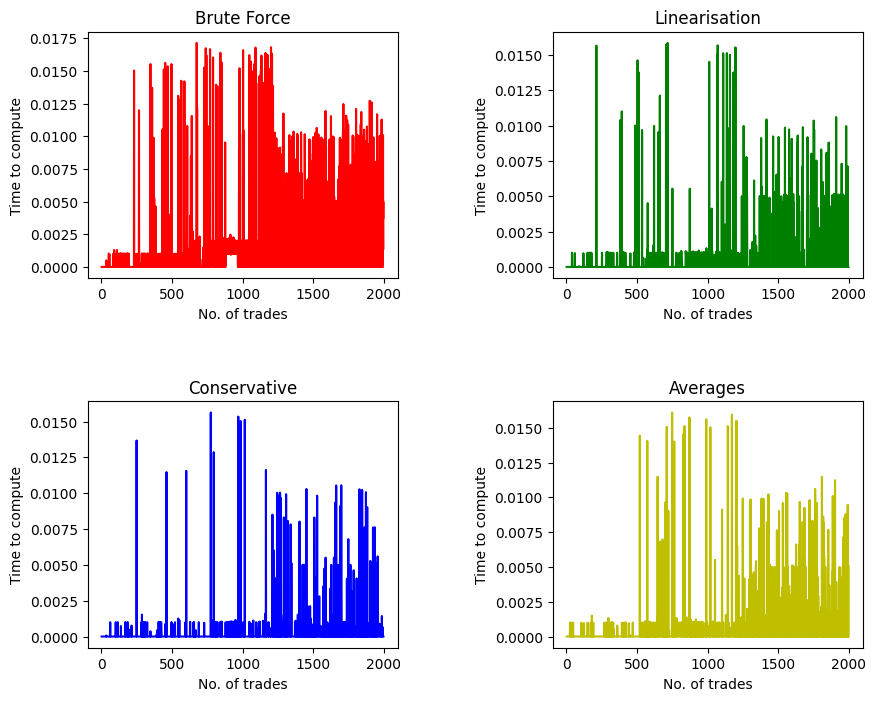

In [92]:
exposure_simulation(2000, 0.01)
